In [3]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import keras


In [4]:
from IPython.display import Image, display


In [2]:
os.listdir()

['dataset_generation.ipynb',
 'dots_prediction - Copy.ipynb',
 'dots_prediction.ipynb',
 'gif_outputs',
 'gif_outputs_3balls',
 'gif_toshow',
 'logs',
 'moving_balls_dataset.npy',
 'moving_balls_dataset_3balls.npy',
 'pred_demo',
 'Research_Note_07_05_2025.pdf']

In [3]:
dataset = np.load("moving_balls_dataset.npy")
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)
print(f"type: {type(dataset)}")
print(f"shape: {dataset.shape}")

type: <class 'numpy.ndarray'>
shape: (2000, 20, 64, 64, 1)


In [4]:
# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

In [5]:
train_dataset.shape

(1800, 20, 64, 64, 1)

In [6]:
# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (1800, 19, 64, 64, 1), (1800, 19, 64, 64, 1)
Validation Dataset Shapes: (200, 19, 64, 64, 1), (200, 19, 64, 64, 1)


Displaying frames for example 575.


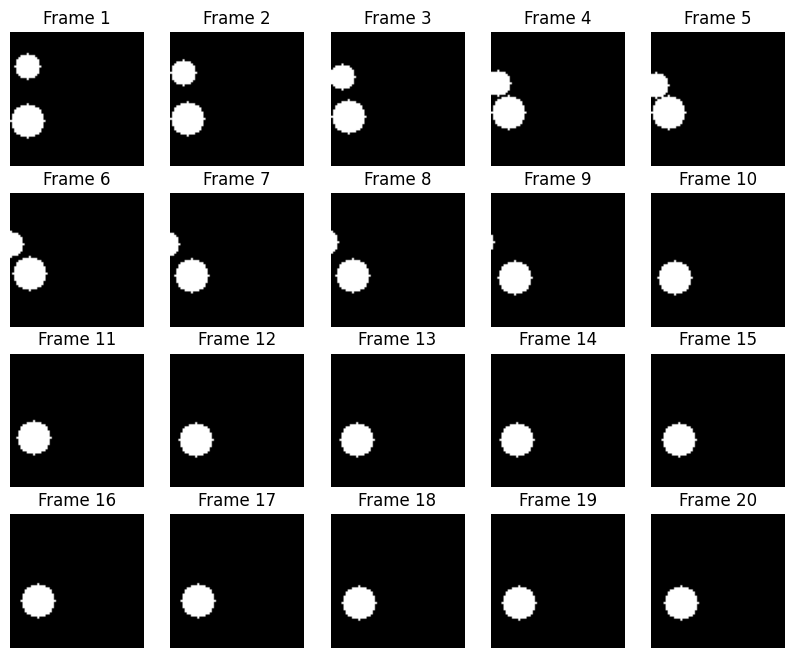

In [13]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
from matplotlib.animation import PillowWriter

def frames2gif(output_dir="gif_toshow",gif_name= f"sample_{data_choice}.gif",ds_demo=train_dataset[data_choice]):

    # 加载数据
    os.makedirs(output_dir, exist_ok=True)

    # 指定想保存的样本索引（可改为 range(len(dataset)) 保存全部）

    frames = ds_demo
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(frames[0], cmap="gray", animated=True)
    ax.axis("off")
    ax.set_title(f"sample")

    def update(frame_idx):
        im.set_array(frames[frame_idx])
        return [im]

    ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=100, blit=True)

    # ✅ 使用 PillowWriter 保存为 GIF
    gif_path = os.path.join(output_dir, gif_name)
    writer = PillowWriter(fps=10)
    ani.save(gif_path, writer=writer)
    plt.close(fig)

    print(f"✅ Saved GIF: {gif_path}")
    display(Image(filename=os.path.join(gif_path)))


✅ Saved GIF: gif_toshow/sample_575.gif


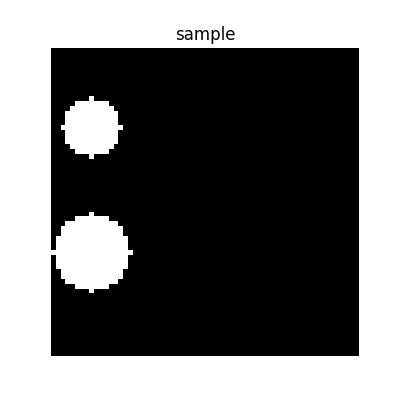

In [17]:
frames2gif()

In [18]:
import logging
import json
import os
from tensorflow.keras.callbacks import Callback
import numpy as np

class JSONMetricsLogger(Callback):
    def __init__(self, log_name="model"):
        super().__init__()
        os.makedirs("logs", exist_ok=True)
        self.log_path = os.path.join("logs", f"{log_name}_metrics.json")

        self.logger = logging.getLogger(f"{log_name}_logger")
        self.logger.setLevel(logging.INFO)
        self.logger.handlers.clear()

        handler = logging.FileHandler(self.log_path, mode="w")
        formatter = logging.Formatter('%(message)s')
        handler.setFormatter(formatter)
        self.logger.addHandler(handler)

    def on_epoch_end(self, epoch, logs=None):
        if logs:
            cleaned_logs = {
                k: float(v) if isinstance(v, (np.floating, float, int)) else str(v)
                for k, v in logs.items()
            }
            cleaned_logs['epoch'] = epoch + 1
            self.logger.info(json.dumps(cleaned_logs))


# ConvLstm with conv3d(3,3,3)

In [29]:
from tensorflow.keras import Sequential, layers, optimizers, losses

convlstm_model = Sequential([
    layers.Input(shape=(None, 64, 64, 1)),  # [B, T, H, W, C]

    layers.ConvLSTM2D(64, (5, 5), padding='same', return_sequences=True, activation='relu'),
    layers.BatchNormalization(),

    layers.ConvLSTM2D(64, (3, 3), padding='same', return_sequences=True, activation='relu'),
    layers.BatchNormalization(),

    layers.ConvLSTM2D(64, (1, 1), padding='same', return_sequences=True, activation='relu'),

    layers.Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same')
], name="convlstm_model")


convlstm_model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.BinaryCrossentropy(),
    metrics=['binary_accuracy']
)


In [30]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
json_logger = JSONMetricsLogger(log_name="convlstm")

# Define modifiable training hyperparameters.
epochs = 20
batch_size = 5

# Fit the model to the training data.
convlstm_model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr, json_logger],
)

Epoch 1/20
  3/360 [..............................] - ETA: 14:03 - loss: 0.6083 - binary_accuracy: 0.9283

KeyboardInterrupt: 

## Prediction Example

In [109]:
def prediction_demo(pred_model=convlstm_model,example_idx = np.random.choice(len(val_dataset), size=1)[0]):
    # Select a random example from the validation dataset.
    example = val_dataset[example_idx]

    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    base_frames = frames
    original_frames = example[10:, ...]

    # Predict a new set of 10 frames.
    for _ in range(10):
        new_prediction = pred_model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
        frames = np.concatenate((frames, predicted_frame), axis=0)

    # Final predicted frames (last 10)
    new_frames = frames[10:, ...]

    # ✅ Create figure with 3 rows: base, original, predicted
    fig, axes = plt.subplots(3, 10, figsize=(20, 6))

    # Plot base (input) frames
    for idx, ax in enumerate(axes[0]):
        ax.imshow(np.squeeze(base_frames[idx]), cmap="gray")
        ax.set_title(f"Input Frame {idx + 1}")
        ax.axis("off")

    # Plot original (ground truth future) frames
    for idx, ax in enumerate(axes[1]):
        ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
        ax.set_title(f"True Frame {idx + 11}")
        ax.axis("off")

    # Plot predicted frames
    for idx, ax in enumerate(axes[2]):
        ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
        ax.set_title(f"Predicted {idx + 11}")
        ax.axis("off")

    print(f"We demonstrate the prediction on validation dataset {example_idx}")

    plt.tight_layout()
    plt.show()
    
    original_all_frames = np.concatenate([base_frames, original_frames], axis=0)
    frames2gif("pred_demo","oringal.gif",original_all_frames)
    
    predict_all_frames = np.concatenate([base_frames, new_frames], axis=0)
    frames2gif("pred_demo",f"predict_{pred_model.name}.gif",predict_all_frames)
    


1/1 [==============================] - 0s 51ms/step
We demonstrate the prediction on validation dataset 9


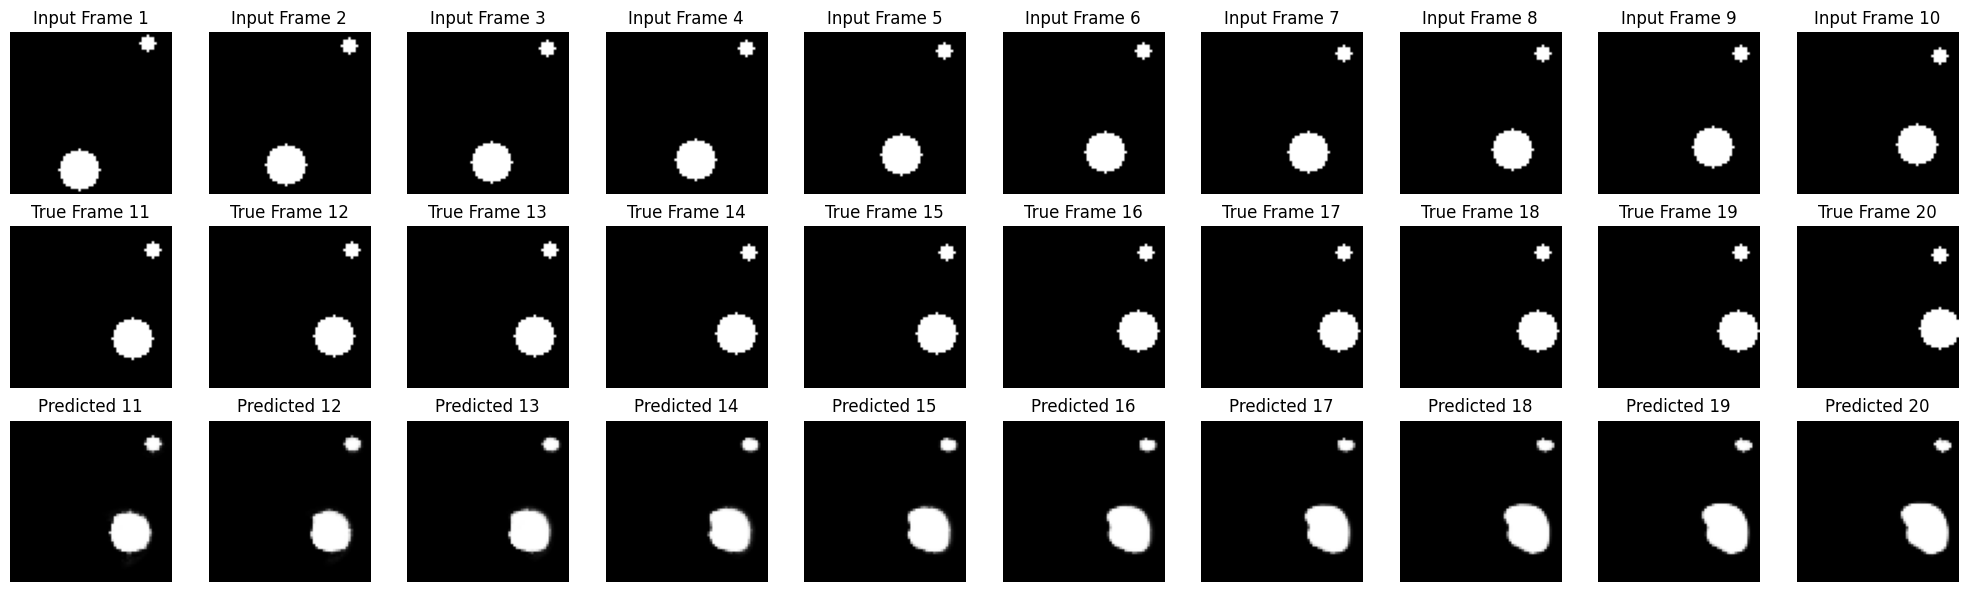

✅ Saved GIF: pred_demo/oringal.gif


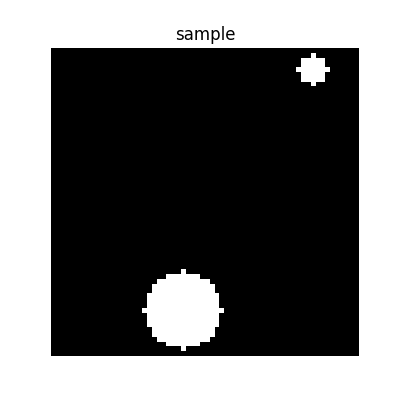

✅ Saved GIF: pred_demo/predict_convlstm_model.gif


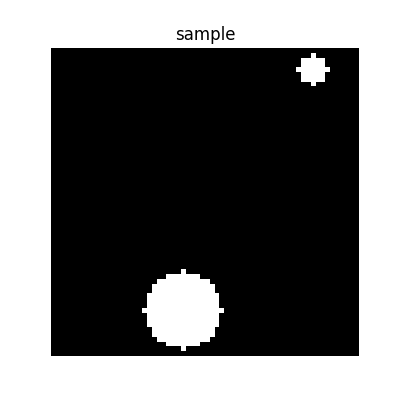

In [111]:
prediction_demo(pred_model=convlstm_model,example_idx=9 )

# ConvLstm with conv3d(1,1,1)

In [ ]:
from tensorflow.keras import Sequential, layers, optimizers, losses

convlstm_model2 = Sequential([
    layers.Input(shape=(None, 64, 64, 1)),  # [B, T, H, W, C]

    layers.ConvLSTM2D(64, (5, 5), padding='same', return_sequences=True, activation='relu'),
    layers.BatchNormalization(),

    layers.ConvLSTM2D(64, (3, 3), padding='same', return_sequences=True, activation='relu'),
    layers.BatchNormalization(),

    layers.ConvLSTM2D(64, (1, 1), padding='same', return_sequences=True, activation='relu'),

    layers.Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same')
], name="convlstm_model2")


convlstm_model2.compile(
    optimizer=optimizers.Adam(),
    loss=losses.BinaryCrossentropy(),
    metrics=['binary_accuracy']
)


In [81]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
json_logger = JSONMetricsLogger(log_name="convlstm2")

# Define modifiable training hyperparameters.
epochs = 20
batch_size = 5

# Fit the model to the training data.
convlstm_model2.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr, json_logger],
)

Epoch 1/20


2025-07-05 04:24:45.414164: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1021] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'Func/gradient_tape/sequential_2/conv_lstm2d_8/while/sequential_2/conv_lstm2d_8/while_grad/body/_555/input/_1530' -> 'gradient_tape/sequential_2/conv_lstm2d_8/while/sequential_2/conv_lstm2d_8/while_grad/body/_555/gradient_tape/sequential_2/conv_lstm2d_8/while/gradients/AddN', 'Func/gradient_tape/sequential_2/conv_lstm2d_7/while/sequential_2/conv_lstm2d_7/while_grad/body/_750/input/_1649' -> 'gradient_tape/sequential_2/conv_lstm2d_7/while/sequential_2/conv_lstm2d_7/while_grad/body/_750/gradient_tape/sequential_2/conv_lstm2d_7/while/gradients/AddN', 'Func/gradient_tape/sequential_2/conv_lstm2d_6/while/sequential_2/conv_lstm2d_6/while_grad/body/_945/input/_1765' -> 'gradient_tape/sequential_2/conv_lstm2d_6/while/sequential_2/conv_lstm2d_6/while_grad/body/_945/gradient_tape/sequential_2/conv

360/360 [==============================] - 56s 149ms/step - loss: 0.0133 - binary_accuracy: 0.9964 - val_loss: 0.1497 - val_binary_accuracy: 0.9618 - lr: 0.0010
Epoch 2/20
360/360 [==============================] - 54s 149ms/step - loss: 4.4809e-04 - binary_accuracy: 0.9998 - val_loss: 7.0367e-04 - val_binary_accuracy: 0.9998 - lr: 0.0010
Epoch 3/20
360/360 [==============================] - 52s 145ms/step - loss: 3.8945e-04 - binary_accuracy: 0.9998 - val_loss: 3.9982e-04 - val_binary_accuracy: 0.9998 - lr: 0.0010
Epoch 4/20
360/360 [==============================] - 53s 146ms/step - loss: 3.6466e-04 - binary_accuracy: 0.9999 - val_loss: 4.0395e-04 - val_binary_accuracy: 0.9998 - lr: 0.0010
Epoch 5/20
360/360 [==============================] - 53s 147ms/step - loss: 3.5345e-04 - binary_accuracy: 0.9999 - val_loss: 3.6387e-04 - val_binary_accuracy: 0.9999 - lr: 0.0010
Epoch 6/20
360/360 [==============================] - 53s 147ms/step - loss: 3.4338e-04 - binary_accuracy: 0.9999 - val

1/1 [==============================] - 0s 43ms/step
We demonstrate the prediction on validation dataset 9


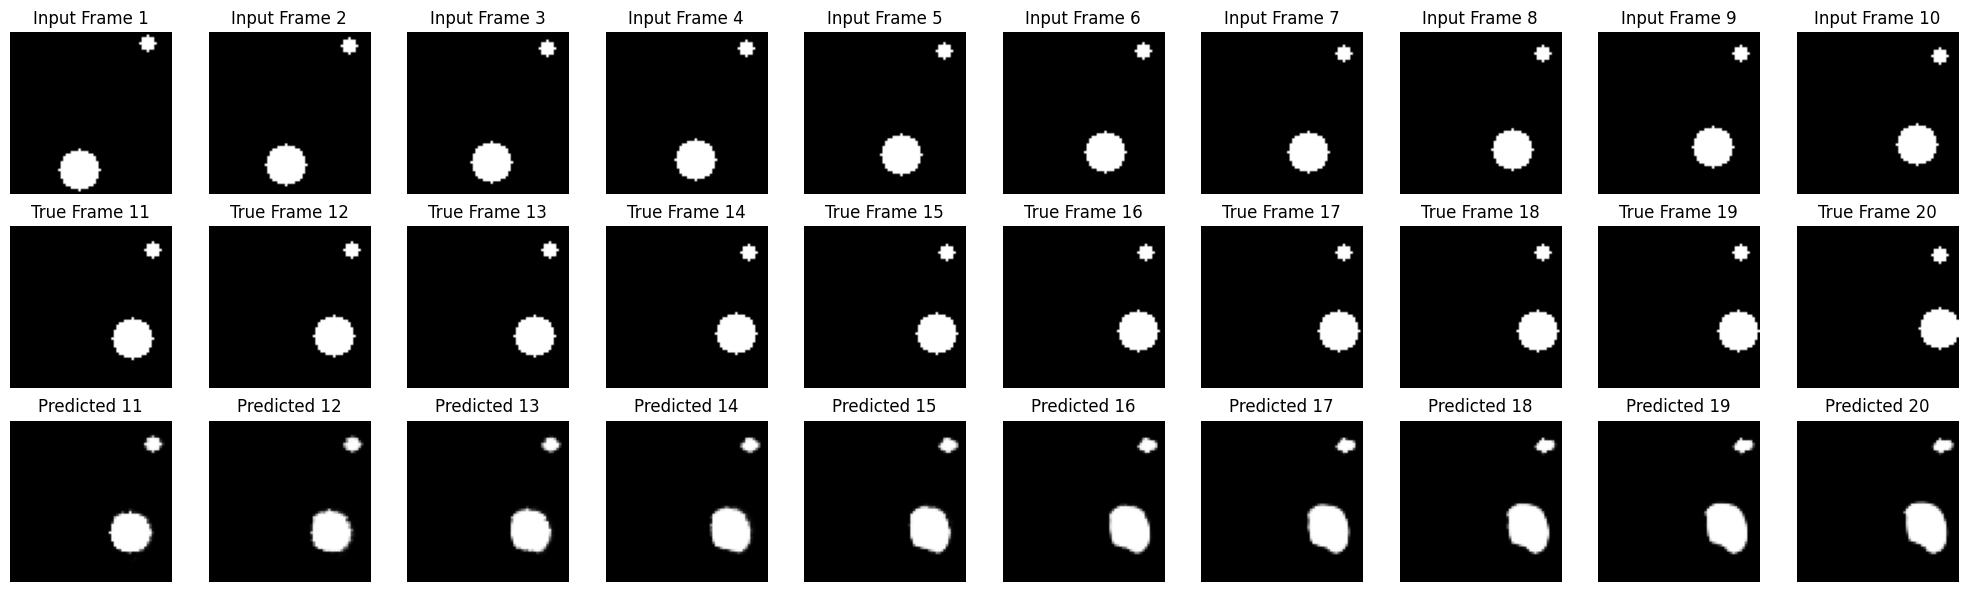

✅ Saved GIF: pred_demo/oringal.gif


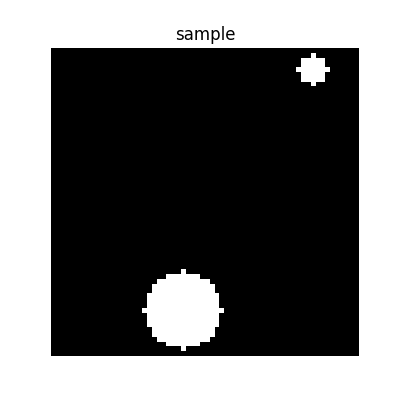

✅ Saved GIF: pred_demo/predict_Sequential.gif


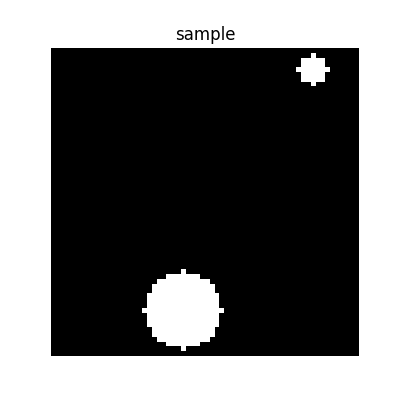

In [99]:
prediction_demo(pred_model=convlstm_model2,example_idx = 9)

# NCP

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


2025-07-06 15:02:04.854892: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-06 15:02:04.899841: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-06 15:02:04.899871: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import keras

2025-07-06 15:01:56.342184: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-06 15:01:56.594030: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-06 15:01:56.594367: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-06 15:01:56.633972: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-06 15:01:56.968554: I tensorflow/core/platform/cpu_feature_guar

In [5]:
dataset = np.load("moving_balls_dataset.npy")
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)
print(f"type: {type(dataset)}")
print(f"shape: {dataset.shape}")

type: <class 'numpy.ndarray'>
shape: (2000, 20, 64, 64, 1)


In [6]:
import numpy as np

# 假设 dataset shape: (N, 20, 64, 64, 1)   ← 每个样本有 20 帧
# 我们要做的是把每个样本拆成：前10帧作为输入，后10帧作为目标

assert dataset.shape[1] >= 20, "需要至少20帧才能做前10帧预测后10帧"

# 归一化
dataset = dataset / 255.0

# 切分 x 和 y
x_all = dataset[:, :10, :, :, :]  # 前10帧
y_all = dataset[:, 10:20, :, :, :]  # 后10帧

# 打乱索引
indexes = np.arange(x_all.shape[0])
np.random.shuffle(indexes)

# 80% train, 10% val, 10% test
train_end = int(0.8 * len(indexes))
val_end = int(0.9 * len(indexes))

train_idx = indexes[:train_end]
val_idx = indexes[train_end:val_end]
test_idx = indexes[val_end:]

# 分割数据集
x_train, y_train = x_all[train_idx], y_all[train_idx]
x_val, y_val = x_all[val_idx], y_all[val_idx]
x_test, y_test = x_all[test_idx], y_all[test_idx]

# 打印确认
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape:   {x_val.shape}")
print(f"y_val shape:   {y_val.shape}")
print(f"x_test shape:  {x_test.shape}")
print(f"y_test shape:  {y_test.shape}")


x_train shape: (1600, 10, 64, 64, 1)
y_train shape: (1600, 10, 64, 64, 1)
x_val shape:   (200, 10, 64, 64, 1)
y_val shape:   (200, 10, 64, 64, 1)
x_test shape:  (200, 10, 64, 64, 1)
y_test shape:  (200, 10, 64, 64, 1)


In [31]:
import tensorflow as tf
tf.config.optimizer.set_jit(True)  # 开启 XLA 编译
from tensorflow.keras import layers, models
from ncps.tf import LTC
from ncps.wirings import AutoNCP

input_shape = (10, 64, 64, 1)  # 输入前 10 帧

ltc_model1 = models.Sequential([
    layers.Input(shape=input_shape),

    # CNN 提取每帧空间特征
    layers.TimeDistributed(layers.Conv2D(32, (5, 5), activation='relu', padding='same')),
    layers.TimeDistributed(layers.MaxPooling2D((2, 2))),
    layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu', padding='same')),
    layers.TimeDistributed(layers.Flatten()),  # 输出 (B, T, Features)

    LTC(AutoNCP(units=256, output_size=128), return_sequences=True),

    layers.TimeDistributed(layers.Dense(8 * 8 * 64, activation='relu')),
    layers.TimeDistributed(layers.Reshape((8, 8, 64))),
    layers.TimeDistributed(layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')),
    layers.TimeDistributed(layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')),
    layers.TimeDistributed(layers.Conv2DTranspose(16, (3, 3), strides=2, padding='same', activation='relu')),  # 加这一层
    layers.TimeDistributed(layers.Conv2D(1, 3, padding='same', activation='sigmoid')),


])

ltc_model1.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)



In [33]:
import numpy as np



# 可选：划分验证集
x_val = x_train[-200:]
y_val = y_train[-200:]
x_train = x_train[:-200]
y_train = y_train[:-200]

# 模型训练
history = ltc_model1.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=6,
    epochs=20
)

Epoch 1/20


2025-07-06 15:43:08.063776: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 384.00MiB (rounded to 402653184)requested by op cluster_22_1/xla_run
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-07-06 15:43:08.063850: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2025-07-06 15:43:08.063857: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 508, Chunks in use: 508. 127.0KiB allocated for chunks. 127.0KiB in use in bin. 10.4KiB client-requested in use in bin.
2025-07-06 15:43:08.063861: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 31, Chunks in use: 31. 16.5KiB allocated for chunks. 16.5KiB in use in bin. 15.7KiB client-requested in use in bin.
202

ResourceExhaustedError: Graph execution error:

Detected at node cluster_22_1/xla_run defined at (most recent call last):
<stack traces unavailable>
Out of memory while trying to allocate 402653184 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  323.26MiB
              constant allocation:        68B
        maybe_live_out allocation:    1.73GiB
     preallocated temp allocation:     3.1KiB
                 total allocation:    1.85GiB
              total fragmentation:     3.2KiB (0.00%)
Peak buffers:
	Buffer 1:
		Size: 384.00MiB
		Operator: op_type="Sum" op_name="sequential_3/ltc_3/while/body/_1/sequential_3/ltc_3/while/ltc_cell_3/Sum" source_file="dummy_file_name" source_line=10
		XLA Label: fusion
		Shape: f32[6,65536,256]
		==========================

	Buffer 2:
		Size: 384.00MiB
		Operator: op_type="Sum" op_name="sequential_3/ltc_3/while/body/_1/sequential_3/ltc_3/while/ltc_cell_3/Sum" source_file="dummy_file_name" source_line=10
		XLA Label: fusion
		Shape: f32[6,65536,256]
		==========================

	Buffer 3:
		Size: 384.00MiB
		Operator: op_type="Sum" op_name="sequential_3/ltc_3/while/body/_1/sequential_3/ltc_3/while/ltc_cell_3/Sum" source_file="dummy_file_name" source_line=10
		XLA Label: fusion
		Shape: f32[6,65536,256]
		==========================

	Buffer 4:
		Size: 384.00MiB
		Operator: op_type="Sub" op_name="sequential_3/ltc_3/while/body/_1/sequential_3/ltc_3/while/ltc_cell_3/sub" source_file="dummy_file_name" source_line=10
		XLA Label: fusion
		Shape: f32[6,65536,256]
		==========================

	Buffer 5:
		Size: 64.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[65536,256]
		==========================

	Buffer 6:
		Size: 64.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[65536,256]
		==========================

	Buffer 7:
		Size: 64.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[65536,256]
		==========================

	Buffer 8:
		Size: 64.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[65536,256]
		==========================

	Buffer 9:
		Size: 64.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[65536,256]
		==========================

	Buffer 10:
		Size: 1.50MiB
		Operator: op_type="Sum" op_name="sequential_3/ltc_3/while/body/_1/sequential_3/ltc_3/while/ltc_cell_3/Sum_4" source_file="dummy_file_name" source_line=10 deduplicated_name="fusion.2"
		XLA Label: fusion
		Shape: f32[6,256,256]
		==========================

	Buffer 11:
		Size: 1.50MiB
		Operator: op_type="Sum" op_name="sequential_3/ltc_3/while/body/_1/sequential_3/ltc_3/while/ltc_cell_3/Sum_4" source_file="dummy_file_name" source_line=10 deduplicated_name="fusion.2"
		XLA Label: fusion
		Shape: f32[6,256,256]
		==========================

	Buffer 12:
		Size: 1.50MiB
		Operator: op_type="Sum" op_name="sequential_3/ltc_3/while/body/_1/sequential_3/ltc_3/while/ltc_cell_3/Sum_2" source_file="dummy_file_name" source_line=10 deduplicated_name="fusion.2"
		XLA Label: fusion
		Shape: f32[6,256,256]
		==========================

	Buffer 13:
		Size: 1.50MiB
		Operator: op_type="Sum" op_name="sequential_3/ltc_3/while/body/_1/sequential_3/ltc_3/while/ltc_cell_3/Sum_2" source_file="dummy_file_name" source_line=10 deduplicated_name="fusion.2"
		XLA Label: fusion
		Shape: f32[6,256,256]
		==========================

	Buffer 14:
		Size: 1.50MiB
		Operator: op_type="Sum" op_name="sequential_3/ltc_3/while/body/_1/sequential_3/ltc_3/while/ltc_cell_3/Sum_2" source_file="dummy_file_name" source_line=10 deduplicated_name="fusion.2"
		XLA Label: fusion
		Shape: f32[6,256,256]
		==========================

	Buffer 15:
		Size: 1.50MiB
		Operator: op_type="Sum" op_name="sequential_3/ltc_3/while/body/_1/sequential_3/ltc_3/while/ltc_cell_3/Sum_2" source_file="dummy_file_name" source_line=10 deduplicated_name="fusion.2"
		XLA Label: fusion
		Shape: f32[6,256,256]
		==========================


	 [[{{node cluster_22_1/xla_run}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_56268]

✅ GIF saved and animated correctly!


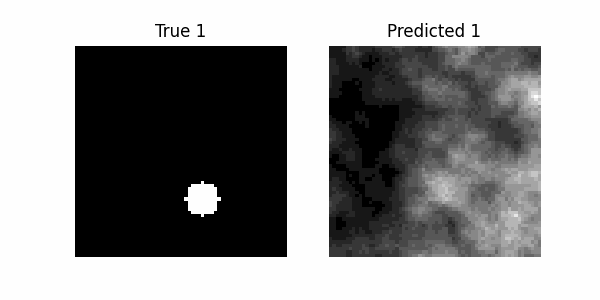

In [24]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO

# 从测试集中取一个样本进行预测
sample_id = 0
x_sample = x_test[sample_id:sample_id+1]  # shape = (1, 10, 64, 64, 1)
y_true = y_test[sample_id]                # shape = (10, 64, 64, 1)

# 模型预测
y_pred = ltc_model1(x_sample)[0]       # shape = (10, 64, 64, 1)

frames = []

for i in range(10):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

    ax1.imshow(y_true[i, :, :, 0], cmap='gray')
    ax1.set_title(f'True {i+1}')
    ax1.axis('off')

    ax2.imshow(y_pred[i, :, :, 0], cmap='gray')
    ax2.set_title(f'Predicted {i+1}')
    ax2.axis('off')

    # 转换 fig → numpy 数组 → imageio frame（避免中间存文件）
    buf = BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    frame = imageio.v2.imread(buf)
    frames.append(frame)
    plt.close(fig)

# 保存为真正多帧动画 gif
imageio.mimsave('ltc_prediction.gif', frames, duration=1, loop=0)

print("✅ GIF saved and animated correctly!")
display(Image(filename=os.path.join("ltc_prediction.gif")))